## CS-502 Deep Learning Project

Table of contents:
### 0) Processing Data, EDA presentation
### 1) CNN vs ViT
### 2) Siamese network approach
### 3) Different Patching methods, shapes sizes, positional encoding, presentation of an image
### 4) attention on channels VGG16 attention
### 5) Siamese network approach to classification

In [54]:
from scripts.imports import *

In [56]:
train_info = pd.read_csv('train.csv')
test_info = pd.read_csv('test.csv')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

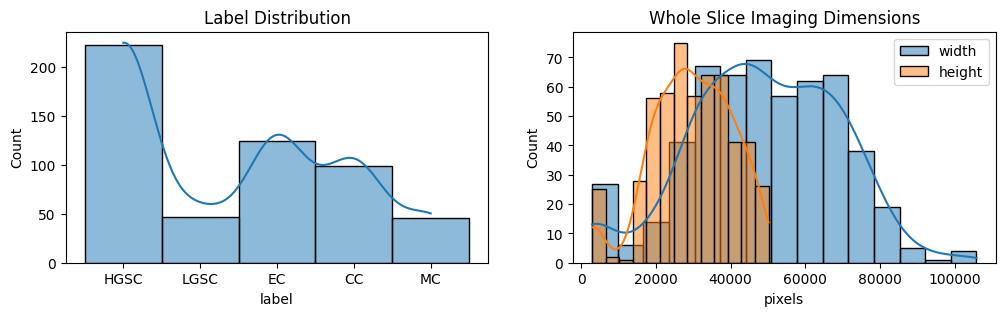

In [57]:
#Train label
fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0].set_title('Label Distribution')
sns.histplot(train_info['label'], kde =True, ax=ax[0])
sns.histplot(train_info['image_width'], kde = True, ax=ax[1], label = 'width', legend = 'True')
sns.histplot(train_info['image_height'], kde = True, ax=ax[1], label = 'height')
ax[1].legend(loc ='upper right')
ax[1].set_xlabel('pixels')
ax[1].set_title('Whole Slice Imaging Dimensions')
plt.show()

In [64]:
for root, dirs, files in sorted(os.walk('train_thumbnails')): train_thumbs = sorted(files) 
for root, dirs, files in sorted(os.walk('masks')): cancer_mask_paths = sorted(files)
print(len(train_thumbs), len(cancer_mask_paths))
MAX_CLASSES = len(train_info.drop_duplicates('label')['label'].values.tolist())
print(train_info.drop_duplicates('label')['label'].values.tolist(), 'max_classes=', MAX_CLASSES)

513 152
['HGSC', 'LGSC', 'EC', 'CC', 'MC'] max_classes= 5


# attention on sick or not sick tissue

In [33]:
class N_conv(nn.Module):
    """
    This a class for defining the N convolution
    Attributes
    ----------
    conv  : nn.Sequential
        defines the train model
    """
    def __init__(self,in_channels,out_channels,N = 2):
        
        super(N_conv,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels,out_channels,kernel_size=(3,3),padding=(1,1)))
        model.append(nn.ReLU(True))
        for i in range(N-1):
            model.append(nn.Conv2d(out_channels,out_channels,kernel_size=(3,3),padding=(1,1)))
            model.append(nn.ReLU(True))
        model.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
        self.conv = nn.Sequential(*model)
        
    def forward(self,x):
        return self.conv(x)
    
class Vgg16(nn.Module):
    """
    This a class for defing the VGG16 model
    Attributes
    ----------
    conv  : nn.Sequential
        defines the train model
    """
    def __init__(self,in_channels=3,out_channels=1,init_weights=True, n_classes = 5):
        super(Vgg16,self).__init__()
        self.conv1 = N_conv(3,64)
        self.conv2 = N_conv(64,128)
        self.conv3 = N_conv(128,256,N=3)
        self.conv4 = N_conv(256,512,N=3)
        self.conv5 = N_conv(512,512,N=3)
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        self.linear1 = nn.Linear(512*7*7,4096)
        self.linear2 = nn.Linear(4096,4096)
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(0.3)
        self.linear3 = nn.Linear(4096,5)
        self.soft = nn.Softmax(dim = 1)
        if init_weights:
            self._initialize_weights()
            
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.soft
        return x

In [34]:
#VGG = Vgg16(in_channels=3, out_channels=1)
#summary(VGG, (3, 200, 200))

In [51]:
class CancerDataset(torch.utils.data.Dataset):
    
    def __init__(
            self,
            images_dir,
            labels_dir,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        #self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.labels_df = pd.read_csv(labels_dir)
        ohe = {}
        for k, v in enumerate(train_info.drop_duplicates('label')['label'].values.tolist()): ohe[v] = k
        self.one_hot_encoder = ohe
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        #print("getting_item", i)
        path = self.image_paths[i]
        image = cv.imread(path).astype('float32')
        
        image_id = int(re.search(r'\d+', path).group())
        #print("image_id", image_id,"df",  self.labels_df['image_id'])
        label = self.labels_df[self.labels_df['image_id'] == image_id]['label'].values.tolist()[0]
        
        label_id = self.one_hot_encoder[label]
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image = image)#, mask=mask)
        
        return image, label_id

    def __len__(self):
        return len(self.image_paths)

def numpy_and_binarize(x):
    return np.where(x.detach().cpu().numpy() > 0.5, 1, 0)

def split_data(dataset, ratio = 0.9):
    total_size = len(dataset)
    train_size = int(ratio * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=400, width=400, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        #album.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.05),
        #album.RGBShift(r_shift_limit=15,g_shift_limit=15, b_shift_limit=15, p=0.5),
        #album.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.1),
        ]
    return album.Compose(train_transform)

def identity(x):
    return x
def one_hot_transf(labels): 
    one_hot_encoded = torch.nn.functional.one_hot(labels, max_classes)
    return one_hot_encoded.to(dtype=torch.float32)
def train_model(x_directory, y_directory, config, use_model=None):

    dataset = CancerDataset(x_directory, y_directory, preprocessing = config['preprocessing'],
                            augmentation = config['augmentation'] )
    train_dataset, validation_dataset = split_data(dataset, ratio = config['train_size'])
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True,
    )#pin_memory=torch.cuda.is_available(), drop_last = False, num_workers = 2)
    validation_loader = DataLoader(validation_dataset, batch_size=config['batch_size'])
    print("Dataloaders")

    n_epochs = config['n_epochs']

    device = config['device']
    model_dict = {"VGG": Vgg16, "ViT": None}
    model_kwargs = config['model_kwargs']
    optimizer_dict = {"AdamW": optim.AdamW}
    loss_function_dict = {"CrossEntropy": nn.CrossEntropyLoss, "BCELoss": nn.BCELoss}
    scheduler_dict  = {'CosineAnnealing': torch.optim.lr_scheduler.CosineAnnealingLR}
    scheduler_kwargs_dict = {'CosineAnnealing': dict(T_max = n_epochs*len(train_loader.dataset))}

    prediction_transform_dict = {"numpy_and_binarize": numpy_and_binarize}
    labels_transform_dict = {"unet_reshape": None, "identity": None, 'one_hot': one_hot_transf}

    model = model_dict[config['model']](**model_kwargs).to(device=device) #Get model
    
    if (use_model is not None):
        model = use_model
    optimizer = optimizer_dict[config['optimizer']](model.parameters(),
                                                    lr = config['learning_rate']) #Get optimizer
    criterion = loss_function_dict[config['loss_function']]() #Get loss function
    
    scheduler = scheduler_dict[config['scheduler']](optimizer, **scheduler_kwargs_dict[config['scheduler']])
    
    prediction_transform = identity
    labels_transform = identity
    if (config['predict_transform'] is not None): prediction_transform = prediction_transform_dict[
        config['prediction_transform']]
        
    if (config['labels_transform'] is not None): labels_transform = labels_transform_dict[
        config['labels_transform']]

    metrics_dict = {"training": [], "validation": []}
    print("Starting Epochs")
    for epoch in range(n_epochs):

        #Model training
        model.train()
        #train_metrics = {'Accuracy': 0, 'F1-score': 0}
        total_train_loss = 0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            #print("inputs", inputs, "labels", labels)
            print(round(batch_idx/len(train_loader),2))
            inputs = torch.permute(inputs, (0, 3, 2, 1))
            inputs = inputs.to(device=device) # inputs: torch.Size([batch, C, 400, 400])
            labels = labels.to(device=device) # labels: torch.Size([batch, C, 400, 400])

            optimizer.zero_grad()
            prediction = model(inputs) # [B, C=1, H, W]
            labels = labels_transform(labels) # Binarize + [B, C=1, H, W]

            #print(type(prediction), type(labels))
            #print(type(prediction), type(labels), prediction.shape, labels.shape, prediction, labels)
            loss = criterion(prediction, labels)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            prediction_class = prediction_transform(prediction) # Binarize
            labels = np.array(labels.detach().cpu().numpy())

            #batch_metrics = metrics(prediction_class.flatten(), labels.flatten())
            #train_metrics['Accuracy'] += batch_metrics['Accuracy']
            #train_metrics['F1-score'] += batch_metrics['F1-score']

        #train_metrics['Accuracy'] /= len(train_loader)
        #train_metrics['F1-score'] /= len(train_loader)
        average_train_loss = total_train_loss/len(train_loader)

        if (epoch + 1) % 1 == 0:
            model.eval()
            #validation_metrics = {'Accuracy': 0, 'F1-score': 0}
            total_validation_loss = 0
            for validation_inputs, validation_labels in validation_loader:
                validation_inputs, validation_labels = (validation_inputs.to(device=device),
                                                        validation_labels.to(device=device))
                validation_inputs = torch.permute(validation_inputs, (0, 3, 2, 1))
                with torch.no_grad():
                    prediction = model(validation_inputs)
                    validation_labels = labels_transform(validation_labels)

                    validation_loss = criterion(prediction, validation_labels)
                    total_validation_loss += validation_loss.item()

                    prediction_class = prediction_transform(prediction)
                    validation_labels = np.array(validation_labels.detach().cpu().numpy())

                    #batch_metrics = metrics(prediction_class.flatten(), validation_labels.flatten())
                    #validation_metrics['Accuracy'] += batch_metrics['Accuracy']
                    #validation_metrics['F1-score'] += batch_metrics['F1-score']

            #validation_metrics['Accuracy'] /= len(validation_loader)
            #validation_metrics['F1-score'] /= len(validation_loader)
            average_validation_loss = total_validation_loss/len(validation_loader)

            #metrics_dict["training"].append(train_metrics)
            #metrics_dict["validation"].append(validation_metrics)
            print('Epoch:', '%03d' % (epoch + 1), 'train loss =', '{:.6f}'.format(average_train_loss), 
                  'val loss =','{:.6f}'.format(average_validation_loss))#,'train accuracy =',' {:.4f}'.format
                  #(train_metrics['Accuracy']), 'val accuracy =','{:.4f}'.format(validation_metrics['Accuracy']),
                  #'validation F1', '{:.4f}'.format(validation_metrics['F1-score']))

    return model, metrics_dict

The task is multi class classification.

In [52]:
def resize(image):
    comp = album.Compose([
        album.Resize(500, 500, p=1, always_apply=True)
    ])
    return comp(image=image)['image']
def identity(x):
    return x
def one_hot_transf(labels): 
    one_hot_encoded = torch.nn.functional.one_hot(labels, MAX_CLASSES)
    return one_hot_encoded.to(dtype=torch.float32)

config_CNN = {
    "model": "VGG",
    "model_kwargs": dict(out_channels = 3, in_channels = 1),
    "preprocessing": resize,
    "augmentation": None,
    "n_epochs": 2,
    "batch_size": 1,
    "optimizer": "AdamW",
    "loss_function": "CrossEntropy",
    "learning_rate": 1e-4,
    "predict_transform": None,
    "labels_transform": 'one_hot',
    "scheduler": "CosineAnnealing",
    "device": DEVICE,
    "train_size": .9
}
vgg = train_model(x_directory = OCEAN + "train_thumbnails", y_directory = OCEAN + "train.csv",
                    config = config_CNN)

Dataloaders
Starting Epochs
0.0
0.0
0.0
0.01
0.01
0.01
0.01
0.02
0.02
0.02
0.02
0.02
0.03
0.03
0.03
0.03
0.03
0.04
0.04
0.04
0.04
0.05
0.05
0.05
0.05
0.05
0.06
0.06
0.06
0.06
0.07
0.07
0.07
0.07
0.07
0.08
0.08
0.08
0.08
0.08
0.09
0.09
0.09
0.09
0.1
0.1
0.1
0.1
0.1
0.11
0.11
0.11
0.11
0.11
0.12
0.12
0.12
0.12
0.13
0.13
0.13
0.13
0.13
0.14
0.14
0.14
0.14
0.15
0.15
0.15
0.15
0.15
0.16
0.16
0.16
0.16
0.16
0.17
0.17
0.17
0.17
0.18
0.18
0.18
0.18
0.18
0.19
0.19
0.19
0.19
0.2
0.2
0.2
0.2
0.2
0.21
0.21
0.21
0.21
0.21
0.22
0.22
0.22
0.22
0.23
0.23
0.23
0.23
0.23
0.24
0.24
0.24
0.24
0.25
0.25
0.25
0.25
0.25
0.26
0.26
0.26
0.26
0.26
0.27
0.27
0.27
0.27
0.28
0.28
0.28
0.28
0.28
0.29
0.29
0.29
0.29
0.3
0.3
0.3
0.3
0.3
0.31
0.31
0.31
0.31
0.31
0.32
0.32
0.32
0.32
0.33
0.33
0.33
0.33
0.33
0.34
0.34
0.34
0.34
0.34
0.35
0.35
0.35
0.35
0.36
0.36
0.36
0.36
0.36
0.37
0.37
0.37
0.37
0.38
0.38
0.38
0.38
0.38
0.39
0.39
0.39
0.39
0.39
0.4
0.4
0.4
0.4
0.41
0.41
0.41
0.41
0.41
0.42
0.42
0.42
0.42
0.43
0.43
0.43

In [7]:
PATCH_SIZE = 50
IMAGE_WIDTH = 1000
IMAGE_HEIGHT = 500
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

#the image width and image height should be divisible by patch size. This is a check to see that.
assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")
NUM_OF_PATCHES

class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

NameError: name 'nn' is not defined